In [3]:
import pandas as pd
from math import floor, ceil
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import soundfile as sf
import os


In [4]:
if not os.path.exists("./extradata"): 
    os.makedirs("./extradata")

In [6]:
data = pd.read_csv("../data/lidar_data_with_audio_timestamps_27_2.csv")
data

,Unnamed: 0,y0,y1,height,width,front_area,datetime_enter,datetime_leave,duration,class_1,class_2,timedelta_start,timedelta_end,audio_start_s,audio_end_s
0,521,335,492,165,157,25905,2022-09-27 14:12:20.875,2022-09-27 14:12:21.155,0.280,medium,medium_small,0 days 00:00:20.876000,0 days 00:00:21.156000,20.0160,22.0160
1,522,358,526,189,168,31752,2022-09-27 14:12:25.676,2022-09-27 14:12:26.143,0.467,medium,medium,0 days 00:00:25.677000,0 days 00:00:26.144000,24.9105,26.9105
2,523,368,549,147,181,26607,2022-09-27 14:12:45.984,2022-09-27 14:12:46.356,0.372,medium,medium_big,0 days 00:00:45.985000,0 days 00:00:46.357000,45.1710,47.1710
3,524,361,607,339,246,83394,2022-09-27 14:13:45.492,2022-09-27 14:13:47.972,2.480,large,large,0 days 00:01:45.493000,0 days 00:01:47.973000,105.7330,107.7330
4,525,57,223,173,166,28718,2022-09-27 14:13:47.866,2022-09-27 14:13:48.158,0.292,medium,medium,0 days 00:01:47.867000,0 days 00:01:48.159000,107.0130,109.0130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,1340,375,549,154,174,26796,2022-09-27 16:08:28.094,2022-09-27 16:08:28.453,0.359,medium,medium_big,0 days 01:56:28.095000,0 days 01:56:28.454000,6987.2745,6989.2745
820,1341,66,236,164,170,27880,2022-09-27 16:08:31.627,2022-09-27 16:08:31.960,0.333,medium,medium,0 days 01:56:31.628000,0 days 01:56:31.961000,6990.7945,6992.7945
821,1342,386,544,151,158,23858,2022-09-27 16:08:32.654,2022-09-27 16:08:33.068,0.414,medium,medium_small,0 days 01:56:32.655000,0 days 01:56:33.069000,6991.8620,6993.8620
822,1343,411,573,161,162,26082,2022-09-27 16:08:35.254,2022-09-27 16:08:35.694,0.440,medium,medium,0 days 01:56:35.255000,0 days 01:56:35.695000,6994.4750,6996.4750


In [7]:
data["entry"] = pd.to_timedelta(data["timedelta_start"]).dt.total_seconds()
data["exit"] = pd.to_timedelta(data["timedelta_end"]).dt.total_seconds()
data = data[["entry", "exit", "class_1"]]
data

,entry,exit,class_1
0,20.876,21.156,medium
1,25.677,26.144,medium
2,45.985,46.357,medium
3,105.493,107.973,large
4,107.867,108.159,medium
...,...,...,...
819,6988.095,6988.454,medium
820,6991.628,6991.961,medium
821,6992.655,6993.069,medium
822,6995.255,6995.695,medium


In [8]:
SR=16000
y, _ = librosa.load("../data/audio_27092022_2.WAV", sr=SR)

In [9]:

train_num = 0
buffer = 0

audio_start, audio_end = 0, 10

len_audio_sec = len(y) // SR

while audio_end < len_audio_sec:
    small_zone = False
    for _, row in data.iterrows():
        vehicle_START, vehicle_END, class_ = row["entry"], row["exit"], row["class_1"]
        small_cond = (audio_start < vehicle_START) and (audio_end > vehicle_END) and (class_=="small")
        if small_cond: small_zone = True
    df = pd.DataFrame(columns=["onset", "offset", "class"])
    active_zone = False
    for j, row in data.iterrows():
        vehicle_START, vehicle_END, class_ = row["entry"], row["exit"], row["class_1"]
        cond = (audio_start < vehicle_START) and (audio_end > vehicle_END)
        if cond and small_zone:
            assert vehicle_START - audio_start < 10, "invalid start time"
            assert vehicle_END - audio_start < 10, "invalid end time"
            df_start = max(0, vehicle_START - audio_start - 1)
            df_end = min(10, vehicle_END - audio_start + 1)
            df.loc[len(df)] = {"onset": df_start, "offset": df_end, "class": class_}
            active_zone = True
    if active_zone:
        onset = int(floor((audio_start-buffer)*SR))
        offset = int(floor((audio_end+buffer)*SR))
        train_path = './extradata/'
        sf.write(f"{train_path}audio_27092022_2_{str(train_num).zfill(4)}.wav", y[onset:offset], SR)  # slice by seconds, seconds in audio = SR * seconds
        df.to_csv(f"{train_path}audio_27092022_2_{str(train_num).zfill(4)}.csv")
        train_num += 1
    audio_start = audio_end
    audio_end += 10

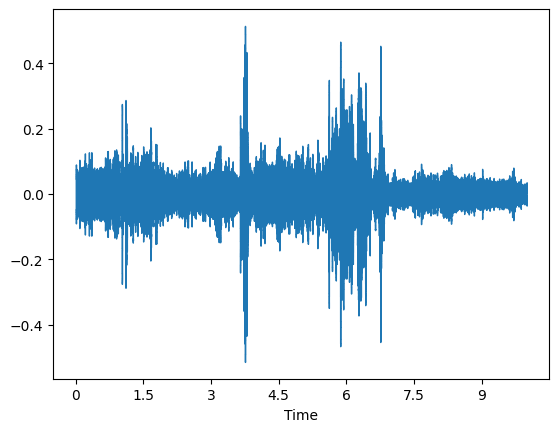

In [31]:
y, _ = librosa.load("./extradata/audio_27092022_2_0002.wav", sr=SR)
display.waveshow(y,sr=SR)

In [33]:
data = pd.read_csv("./extradata/audio_27092022_2_0002.csv")
data

,Unnamed: 0,onset,offset,class
0,0,0.000,1.533,medium
1,1,1.026,3.053,small
2,2,1.013,3.466,medium
3,3,4.306,6.626,medium
4,4,7.519,9.879,medium
5,5,8.133,10.000,small


In [34]:
def manipulate_shift(data, sampling_rate, shift_max, shift_direction):
    #shift = np.random.randint(sampling_rate * shift_max)
    shift = sampling_rate * shift_max
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift    
    
    augmented_data = np.roll(data, shift)
    return augmented_data

In [35]:
def manipulate_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

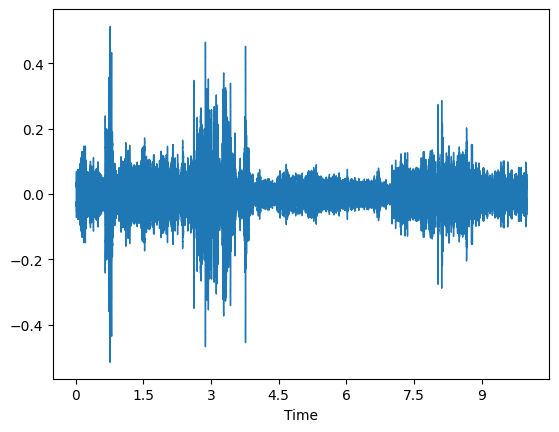

In [36]:
y_shift = manipulate_shift(y, SR, shift_max=3, shift_direction='right')
display.waveshow(y_shift, sr=SR)

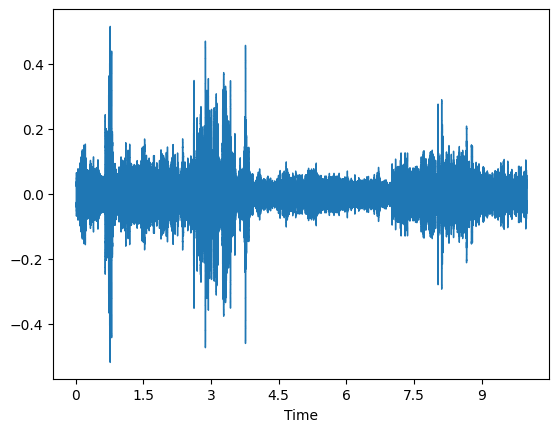

In [37]:
y_shift_noise = manipulate_noise(y_shift, 0.004)
display.waveshow(y_shift_noise, sr=SR)